# Cargo los datos desde el CSV (ejecutar una sola vez)

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import metnum
from utils import graficarPropXPrecio, cmlConKFold, cml


df_completo = pd.read_csv('../data/train.csv')

In [2]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240000 non-null  int64  
 1   titulo                      234613 non-null  object 
 2   descripcion                 238381 non-null  object 
 3   tipodepropiedad             239954 non-null  object 
 4   direccion                   186928 non-null  object 
 5   ciudad                      239628 non-null  object 
 6   provincia                   239845 non-null  object 
 7   antiguedad                  196445 non-null  float64
 8   habitaciones                217529 non-null  float64
 9   garages                     202235 non-null  float64
 10  banos                       213779 non-null  float64
 11  metroscubiertos             222600 non-null  float64
 12  metrostotales               188533 non-null  float64
 13  idzona        

In [3]:
df_completo['ciudad'].value_counts()

Querétaro          12646
Benito Juárez      11014
Zapopan            10360
San Luis Potosí     7925
Mérida              7162
                   ...  
Dzoncauich             1
Jiménez                1
Chapantongo            1
TacAmbaro              1
Tzucacab               1
Name: ciudad, Length: 875, dtype: int64

# Buscando la variable mas correlacionada con precio

El objetivo de este experimento es encontrar que variable está más correlacionada con el precio, para ello veremos gráficos de correlación, como también crearemos estimadores lineales de una única variable y veremos cuánto error tienen.

# Metros cubiertos
Intuimos que los metros cubiertos están fuertemente relacionados al precio, veamos qué tanto, para ello primero segmentaremos los datos por ciudad, probando primero con Querétaro (la ciudad con más información en nuestra base de datos), luego Benito Juárez y por último Mérida.

In [4]:
#Filtramos la data por ciudad creando 3 DataFrames
df_quer = df_completo[df_completo['provincia']=='Distrito Federal']
df_beni = df_completo[df_completo['provincia']=='Edo. de México']
df_meri = df_completo[df_completo['provincia']=='Jalisco']

def dfs(prop):
    return [df_quer.dropna(subset=[prop]), df_beni.dropna(subset=[prop]), df_meri.dropna(subset=[prop])]

nombres = ["Distrito Federal", "Edo. de México", "Jalisco"]

Observemos cómo se ve el gráfico de Metros cubiertos x precio

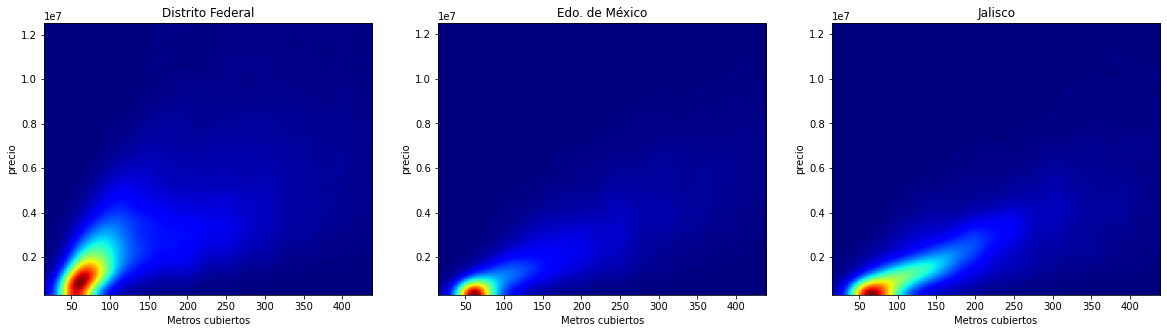

In [9]:
graficarPropXPrecio('metroscubiertos', "Metros cubiertos", dfs("metroscubiertos"), nombres, 3)


Pareciera haber una relación bastante lineal, Benito Juárez siendo el caso más extraño, con una correlación aparentemente baja.
Estudiemos qué sucede al tomar $\phi_{Metros\_cubiertos}(x) = x$. Ejecutaremos CML para los tres ejemplos y compararemos cuán bien predice para cada caso. Nuestra esperanza es que habiendo visto los gráficos performe razonablemente bien en Queretaro.

In [ ]:
cmlConKFold('metroscubiertos', lambda x: x,dfs('metroscubiertos'), nombres,2)

Efectivamente en Querétaro es posible estimar el precio de una propiedad basado únicamente en los metros cubiertos más eficientemente que en Benito Juárez o Mérida.

# Antigüedad

Observemos la antigüedad x precio en busca de cuál es la $\phi$ que mejor aproxime.

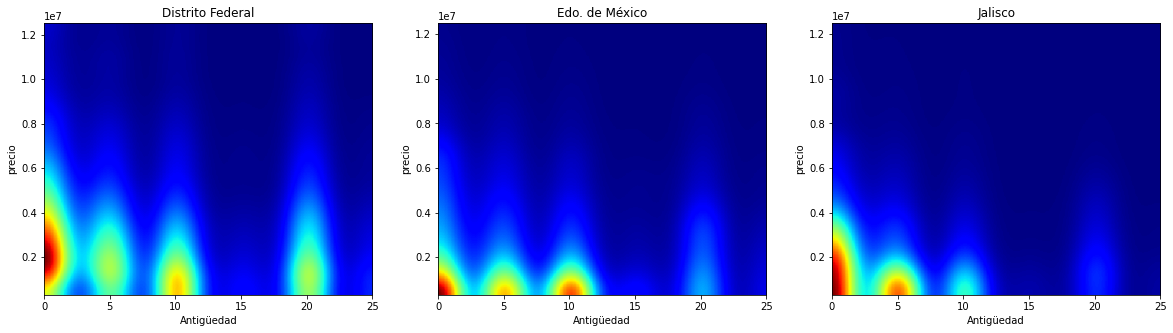

In [16]:
pd.set_option('display.max_rows', None)
dfscopados = dfs('antiguedad')
for i in range(3):
    dfscopados[i] = dfscopados[i][dfscopados[i]['antiguedad'] <= 25]

graficarPropXPrecio('antiguedad', "Antigüedad", dfscopados , nombres, 5)
# df_res = pd.DataFrame()
# df_res['size'] = df_df.groupby('antiguedad')['precio'].size()
# df_res['precioPromedio'] = df_df.groupby('antiguedad')['precio'].mean()
# print(df_res)

Podemos ver que en Benito Juarez y en Merida se puede apreciar cierta importancia a que no sea viejo. Es decir, podemos ver como los inmuebles mas caros son nuevos. Sin embargo esto no es tan asi en Queretaro donde creemos que esta variable resulta irrelevante.

# Decisión de $\phi$ : $\phi_{antiguedad}(x) = \frac{1}{x+1}$

Mirando los gráficos podemos ver que tanto en Queretaro como en Merida es dificil encontrar inmuebles caros y al mismo tiempo antiguos. Esto nos da la pauta para proponer una función decreciente en $x$, sabemos que no por nuevo un departamento es necesariamente caro, sin embargo para dos departamentos iguales creemos que el hecho de que sea más nuevo debería subir su precio.

Probemos cuán bien performa esta $\phi$ a la hora de estimar el precio de los inmuebles. 

In [ ]:
cml('antiguedad', lambda x: (1/(x+1)), dfs, nombres)

Lo primero que se observa es como la antiguedad no estima ni de cerca tan bien el precio como lo hacen los metros cubiertos. Esto es razonable, observemos los gráficos, podemos ver que hay muchos departamentos baratos y al mismo tiempo nuevos.  

Lo segundo a mencionar es que en Benito Juarez esta medida no tiene sentido alguno, la antiguedad no define nada, podriamos elegir otro $\phi$ pero en este caso particular creemos que es mejor ignorar completamente la variable ya que no parece haber una correlación _distinta_ si no una **falta de correlación**.

Otra cosa un poco extraña que descubrimos es que probando la función $\phi_{antiguedad}(x) = \frac{1}{x+k}$ nos dio mejores resultados para $k$ mayores.  
Por ejemplo $k=7$:


In [ ]:
cml('antiguedad', lambda x: (1/(x+7)), dfs, nombres)

Si seguimos aumentando el k podemos ver como el error sigue bajando, probemos $k=1000$

In [ ]:
cml('antiguedad', lambda x: (1/(x+1000)), dfs, nombres)

por último veamos $k=1x10^8$:

In [ ]:
cml('antiguedad', lambda x: (1/(x+100000000)), dfs, nombres)

Creemos que este efecto es una consecuencia

In [ ]:
cmlConKFold('antiguedad', lambda x: (1/(x+100000000)), dfs, nombres, 5)